# Predicting Default in Online Unsecured Personal Loans

In [1]:
%matplotlib inline
import os 
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
dta = pd.read_pickle("..\\outfiles\\clean_dta.pkl")

## 1. Feature Engineering

<b> Some thoughts </b>: What happens during a loan application? The investor is selling the ability to shift capital. The borrower wants to maximize this flexibility regardless of their "type" (creditworthy vs uncreditworthy), which only they observe (assume for now the "bad" types know they're going to default). The intermediary's goal is to accurately determine the borrower's type (<b><i>Stiglitz and Weiss 1981</i></b>). 

1) The borrower only provides additional information if it acts as a positive signal of creditworthiness. <br>
2) If the intermediary's screening technology is imperfect, uncreditworthy borrowers will send signals to try to pool themselves with credit worthy borrowers. <br>

The combination of the two points above suggest information in which the applicant can choose what to signal (e.g. <b> soft information </b>), such as a description for their loan purpose, is likely to be very informative to detect "uncreditworthy" behavior. More on this in ``section 1.2``.

<br>
<b>Business and Engineering Perspective</b>: What tools can we use to determine feature relevance?

1) Drop columns that won't help, such as example IDs (common sense).  <br>
2) Then, there are a few tools to help with dimension reduction, including the following: 

- Feature Importance from Decision tree classifiers <br>
- Subset selection <br>
- PCA <br>

With <100 columns and >39,000 observations, there is unlikely a dimensionality issue.

#### 1.1 Engineering credit and personal (hard) features

In [3]:
# Filter features by low variance first
dta.var().sort_values()

policy_code                   0.000000e+00
collections_12_mths_ex_med    0.000000e+00
chargeoff_within_12_mths      0.000000e+00
tax_liens                     2.384131e-05
acc_now_delinq                9.535843e-05
int_rate                      1.364061e-03
pub_rec_bankruptcies          4.231771e-02
pub_rec                       6.030469e-02
has_pub_rec                   7.899684e-02
revol_util                    8.076980e-02
target                        1.163695e-01
has_desc                      2.147639e-01
has_delin                     2.326042e-01
delinq_2yrs                   2.628551e-01
inq_last_6mths                2.349314e+00
open_acc                      2.025178e+01
dti                           4.522739e+01
total_rec_late_fee            6.042360e+01
total_acc                     1.301785e+02
mths_since_last_delinq        5.026746e+02
delinq_amnt                   8.735345e+02
fico_range_high               1.311057e+03
fico_range_low                1.311057e+03
out_prncp_i

In [4]:
features = ['loan_amnt',
            'term',            
            'emp_length',
            'home_ownership',
            'annual_inc',            
            'dti',
            'last_fico_range_high',
            'has_desc',
            'has_delin',
            'inq_last_6mths',  
            'verification_status',
            'open_acc',            
            'revol_bal',
            'revol_util',
            'total_acc',                                    
            'addr_state',
            'purpose']

<AxesSubplot:>

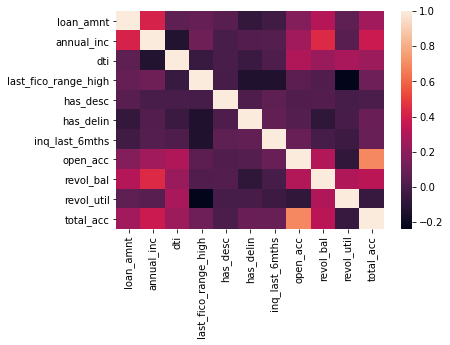

In [5]:
fig, ax = plt.subplots()
sns.heatmap(dta[features].corr(), ax = ax)

In [6]:
features.remove('open_acc') # high collinearity with tot_accs

#### 1.2 Import Bigrams

In [7]:
from nltk.util import ngrams
import pickle

In [8]:
with open('..\\outfiles\\top_grams.pkl', 'rb') as f:
    top_grams = pickle.load(f)
    
with open('..\\outfiles\\chgoff_grams.pkl', 'rb') as f:
    chgoff_grams = pickle.load(f)

with open('..\\outfiles\\paid_grams.pkl', 'rb') as f:
    paid_grams = pickle.load(f)

In [9]:
all_grams = top_grams + chgoff_grams + paid_grams

#### 1.3 Encoding

In [ ]:
# bin ficos 
#dta['last_fico_range_high'].describe().to_frame().transpose()
#dta['fico_bins'] = pd.cut(dta['last_fico_range_high'], bins = [499, 600, 700, 800], right = False)
#features.remove('last_fico_range_high') # high collinearity with tot_accs
#features.append('fico_bins') # high collinearity with tot_accs

In [12]:
# one-hot encode categorical features
# to_encode = ['home_ownership', 'emp_length', 'term', 'addr_state', 'purpose', 'verification_status', 'fico_bins']
to_encode = ['home_ownership', 'emp_length', 'term', 'addr_state', 'purpose', 'verification_status']

In [13]:
# manually one hot encode bigrams
text_features = []

for i, bigram in enumerate(all_grams):
    mask = dta['bigrams'].apply(lambda x: bigram in x)
    dta['bigram' + str(i)] = mask.astype(int)
    text_features.append('bigram' + str(i))

#### 1.4.1 Feature Selection (pt1) Dimensionality reduction
- instead of 25 features with bigrams of high odds, capture into 1 dummy var (and vice versa for bigrams with low odds)

In [14]:
dta['low_odd_grams']=dta.loc[:,'bigram225':'bigram247'].sum(axis = 1)
dta['high_odd_grams']=dta.loc[:,'bigram200':'bigram224'].sum(axis = 1)
features.append('low_odd_grams')
features.append('high_odd_grams')

#### 1.4.2 Feature Selection (pt2) Data Split to determine bigram importance

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
features_w_text = features + text_features

X = pd.get_dummies(dta[features_w_text], columns = to_encode)
y = dta['target']

X.columns = X.columns.str.replace(",", "")
X.columns = X.columns.str.replace(">", "")
X.columns = X.columns.str.replace("<", "")
X.columns = X.columns.str.replace("[", "", regex = False)
X.columns = X.columns.str.replace("]", "", regex = False)
X.columns = X.columns.str.replace("(", "", regex = False)
X.columns = X.columns.str.replace(")", "", regex = False)

fin_features = [x for x in X.columns.to_list() if x not in text_features]

# Try feature space without text first 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 42)

#### 1.4.3 Feature selection (pt3): Feature Importance of bigrams

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 15, criterion = 'entropy', max_depth = 50)
dt.fit(X_train[text_features],y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=50, random_state=15)

In [18]:
fi_col = []
fi = []

for i, column in enumerate(X_train[text_features]):
    # print("The feature importance for {} is {}".format(column, dt.feature_importances_[i]))    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature', 'Feature Importance'])
fi_df = fi_df.sort_values(by='Feature Importance', ascending = False)
fi_df[0:49]

,Feature,Feature Importance
2,bigram2,0.015012
5,bigram5,0.015006
7,bigram7,0.014833
31,bigram31,0.013186
1,bigram1,0.012965
6,bigram6,0.012956
9,bigram9,0.012882
21,bigram21,0.012538
14,bigram14,0.012155
27,bigram27,0.011960


In [19]:
# text_features - list of all 250 bigrams
# text_features2 - list of top 25 bigrams by feature importance
text_features2 = list(fi_df['Feature'][0:25])

#### 1.6 Finalize training sets:
- 1) Training set without any bigram features
- 2) Training set with top 50 bigram features

In [20]:
#list of bigrams to drop
drop_bigrams = [x for x in text_features if x not in text_features2]

#list of features w text
features_w_text = [x for x in X_train.columns.to_list() if x not in drop_bigrams]

In [21]:
X_train = X_train[features_w_text]
X_test = X_test[features_w_text]

X_train_f = X_train[fin_features]
X_test_f = X_test[fin_features]

In [22]:
print(X_train.shape)
X_train_f.shape

(33555, 122)


(33555, 97)

## 2. Modeling

In this project, I will fit <b>Random Forest (RF)</b> and <b>Gradient Boosting (XGB)</b> on two different feature spaces to predict loan default/charge-off. I'll try the feature space without text first, then the features that include the bigrams.

It will be interesting to compare the performance across these models and across feature spaces. Some questions to keep in mind include: <br>

- How does RF compare against XGBoost in loan prediction? Will XGBoost overfit to the noise in the training set? 
- As models become more sophisticated and less interpretable, how can one ensure it is compliant with fair lending laws? <b>(Bartlett, Stanton, Morse and Wallace 2019)</b>


In [23]:
# tools for sample splitting
from sklearn.model_selection import train_test_split, KFold,RepeatedStratifiedKFold, cross_val_score

# Models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Performance Metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import accuracy_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV # cross val
from sklearn.metrics import plot_confusion_matrix # draw confusion matrix

# Class Rebalancing
#!pip install imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.utils import shuffle

### 2.1 Building Pipeline(s)

In [24]:
from imblearn.pipeline import Pipeline, make_pipeline

In [25]:
# Sampling techniques
sm = SMOTE(random_state = 99)
rus = RandomUnderSampler(random_state = 99)
ros = RandomOverSampler(random_state = 99)

# CV technique 
kf = KFold(n_splits = 5, shuffle= False)

# Models
log = LogisticRegression(random_state = 123)
rf = RandomForestClassifier(random_state = 123)

xtreme = xgb.XGBClassifier(objective = 'binary:logistic', 
                        eval_metric = 'logloss',
                        seed = 123,
                        use_label_encoder = False)

In [26]:
log_pipeline = Pipeline([("over", ros), ("log", log)])
rf_pipeline = Pipeline([("over", ros), ("rf", rf)])
xtreme_pipeline = Pipeline([("over", ros), ("xtreme", xtreme)])

In [40]:

log_param_grid = [
   {        
        "log__C": [0.1],
        "log__penalty": ['l2'],
        "log__solver": ['lbfgs'],
    },
]

rf_param_grid = [
    {
        "rf__n_estimators": [30,40,50,60],
        "rf__max_depth": [10,15,20,25,30],        
        "rf__max_features": [10,15,20],        
    },    
]

xtreme_param_grid = [
    {        
        "xtreme__max_depth": [3,6,9],
        "xtreme__alpha": [0.1,0.5,1],
        "xtreme__lambda": [0.1,0.5,1],
    },
]

In [41]:
rf_grid = GridSearchCV(rf_pipeline,
                      param_grid = rf_param_grid,
                      cv = kf,
                      scoring = 'recall',
                      return_train_score = True)

log_grid = GridSearchCV(log_pipeline,
                        param_grid = log_param_grid,
                        cv = kf,
                        scoring = 'recall',
                        return_train_score = True)

xtreme_grid = GridSearchCV(xtreme_pipeline,
                      param_grid = xtreme_param_grid,
                      cv = kf,
                      scoring = 'recall',
                      return_train_score = True)

#### 2.2 Train, tune hyperparameters and Test model

In [52]:
def train_model(model, train_set):
    model.fit(train_set, y_train)
    
    best_params = model.best_params_
    best_score = '{:.3f}'.format(model.best_score_)
    
    print(f"The best params: {best_params}")
    print(f"Best Score: {best_score}")
    
def test_model(model, test_set, label = ''):        
    y_pred = model.predict(test_set)
    
    w_recall = '{:.3f}'.format(recall_score(y_test, y_pred, average = 'weighted'))
    w_precision = '{:.3f}'.format(precision_score(y_test, y_pred, average = 'weighted'))
    
    recall_0 = '{:.3f}'.format(recall_score(y_test, y_pred, pos_label = 0))
    precision_0 = '{:.3f}'.format(precision_score(y_test, y_pred, pos_label = 0))
    
    recall_1 = '{:.3f}'.format(recall_score(y_test, y_pred, pos_label = 1))
    precision_1 = '{:.3f}'.format(precision_score(y_test, y_pred, pos_label = 1))
        
    print(f"Recall for {label}: {recall_1}")    
    print(classification_report(y_test, y_pred))
    

In [30]:
# logit - Only fin features
train_model(log_grid, X_train_f)
test_model(log_grid, X_test_f, label = 'Fin features only')

# logit - Fin and text features
train_model(log_grid, X_train)
test_model(log_grid, X_test, label = 'Fin and Text features')

The best params: {'log__C': 0.1, 'log__penalty': 'l2', 'log__solver': 'lbfgs'}
Best Score: 0.510
Weighted recall for Fin features only: 0.691
Weighted precision for Fin features only: 0.806
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      7216
           1       0.23      0.50      0.31      1173

    accuracy                           0.69      8389
   macro avg       0.56      0.61      0.56      8389
weighted avg       0.81      0.69      0.73      8389



C:\Users\Danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The best params: {'log__C': 0.1, 'log__penalty': 'l2', 'log__solver': 'lbfgs'}
Best Score: 0.510
Weighted recall for Fin and Text features: 0.691
Weighted precision for Fin and Text features: 0.806
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      7216
           1       0.23      0.50      0.31      1173

    accuracy                           0.69      8389
   macro avg       0.56      0.61      0.56      8389
weighted avg       0.81      0.69      0.73      8389



In [53]:
# rf - Only fin features
train_model(rf_grid, X_train_f)
test_model(rf_grid, X_test_f, label = 'Fin features only')
rf_probs_f = rf_grid.predict_proba(X_test_f)

# rf - Fin and text features
train_model(rf_grid, X_train)
test_model(rf_grid, X_test, label = 'Fin and Text features')
rf_probs = rf_grid.predict_proba(X_test)

The best params: {'rf__max_depth': 15, 'rf__max_features': 20, 'rf__n_estimators': 50}
Best Score: 0.825
Recall for Fin features only: 0.812
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7216
           1       0.44      0.81      0.57      1173

    accuracy                           0.83      8389
   macro avg       0.70      0.82      0.73      8389
weighted avg       0.89      0.83      0.85      8389

The best params: {'rf__max_depth': 15, 'rf__max_features': 20, 'rf__n_estimators': 50}
Best Score: 0.830
Recall for Fin and Text features: 0.824
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7216
           1       0.43      0.82      0.57      1173

    accuracy                           0.82      8389
   macro avg       0.70      0.82      0.73      8389
weighted avg       0.89      0.82      0.84      8389



In [54]:
# xgb - Only fin features
train_model(xtreme_grid, X_train_f)
test_model(xtreme_grid, X_test_f, label = 'Fin features only')
xtreme_probs_f = xtreme_grid.predict_proba(X_test_f)

# xgb - Fin and text features
train_model(xtreme_grid, X_train)
test_model(xtreme_grid, X_test, label = 'Fin and Text features')
xtreme_probs = xtreme_grid.predict_proba(X_test)

The best params: {'xtreme__alpha': 1, 'xtreme__lambda': 1, 'xtreme__max_depth': 9}
Best Score: 0.593
Recall for Fin features only: 0.604
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7216
           1       0.51      0.60      0.55      1173

    accuracy                           0.86      8389
   macro avg       0.72      0.75      0.74      8389
weighted avg       0.87      0.86      0.87      8389

The best params: {'xtreme__alpha': 1, 'xtreme__lambda': 1, 'xtreme__max_depth': 9}
Best Score: 0.603
Recall for Fin and Text features: 0.624
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7216
           1       0.52      0.62      0.56      1173

    accuracy                           0.87      8389
   macro avg       0.73      0.76      0.74      8389
weighted avg       0.88      0.87      0.87      8389



#### 2.3 Evaluation: AUC

## ROC Curve

In [45]:
# Create a diagonal line for random prediction
random_probs = [0 for _ in range(len(y_test))]

random_auc = roc_auc_score(y_test, random_probs)
rf_auc = roc_auc_score(y_test, rf_probs[:,1])
rf_f_auc = roc_auc_score(y_test, rf_probs_f[:,1])

# retain just the positive probs
random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs[:,1])
rf_f_fpr, rf_f_tpr, _ = roc_curve(y_test, rf_probs_f[:,1])

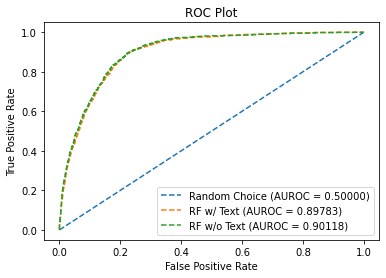

In [46]:
plt.plot(random_fpr, random_tpr, linestyle = '--', label='Random Choice (AUROC = %0.5f)' % (random_auc))
plt.plot(rf_fpr, rf_tpr, linestyle = '--', label='RF w/ Text (AUROC = %0.5f)' % (rf_auc))
plt.plot(rf_f_fpr, rf_f_tpr, linestyle = '--', label='RF w/o Text (AUROC = %0.5f)' % (rf_f_auc))

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC_curve_rf.jpg')
plt.show()

In [47]:
# Create a diagonal line for random prediction
random_probs = [0 for _ in range(len(y_test))]

random_auc = roc_auc_score(y_test, random_probs)
xtreme_auc = roc_auc_score(y_test, xtreme_probs[:,1])
xtreme_f_auc = roc_auc_score(y_test, xtreme_probs_f[:,1])

# retain just the positive probs
random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)

xtreme_fpr, xtreme_tpr, _ = roc_curve(y_test, xtreme_probs[:,1])
xtreme_f_fpr, xtreme_f_tpr, _ = roc_curve(y_test, xtreme_probs_f[:,1])

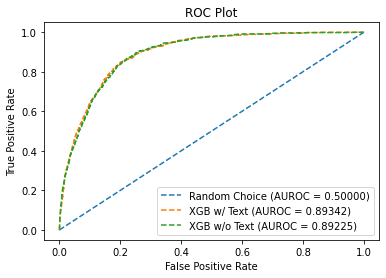

In [48]:
plt.plot(random_fpr, random_tpr, linestyle = '--', label='Random Choice (AUROC = %0.5f)' % (random_auc))
plt.plot(xtreme_fpr, xtreme_tpr, linestyle = '--', label='XGB w/ Text (AUROC = %0.5f)' % (xtreme_auc))
plt.plot(xtreme_f_fpr, xtreme_f_tpr, linestyle = '--', label='XGB w/o Text (AUROC = %0.5f)' % (xtreme_f_auc))

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC_curve_xgb.jpg')
plt.show()

In [49]:
rf_importances = rf_grid.best_estimator_.named_steps['rf'].feature_importances_
xtreme_importances = xtreme_grid.best_estimator_.named_steps['xtreme'].feature_importances_

In [50]:
rf_fi_col = []
rf_fi = []

for i, column in enumerate(X_train):
    # print("The feature importance for {} is {}".format(column, dt.feature_importances_[i]))    
    rf_fi_col.append(column)
    rf_fi.append(rf_importances[i])

rf_fi_df = zip(rf_fi_col, rf_fi)
rf_fi_df = pd.DataFrame(rf_fi_df, columns = ['Feature', 'Feature Importance'])
rf_fi_df = rf_fi_df.sort_values(by='Feature Importance', ascending = False)
rf_fi_df[0:49]
rf_fi_df['Feature'] = rf_fi_df['Feature'].replace(['bigram0'], str(top_grams[0]))
rf_fi_df['Feature'] = rf_fi_df['Feature'].replace(['bigram2'], str(top_grams[2]))
rf_fi_df['Feature'] = rf_fi_df['Feature'].replace(['bigram5'], str(top_grams[5]))
rf_fi_df[0:49]

,Feature,Feature Importance
3,last_fico_range_high,0.618524
8,revol_util,0.034391
6,inq_last_6mths,0.031124
1,annual_inc,0.030216
7,revol_bal,0.026206
2,dti,0.025791
0,loan_amnt,0.025315
54,term_ 60 months,0.024992
9,total_acc,0.022611
53,term_ 36 months,0.020743


In [51]:
xtreme_fi_col = []
xtreme_fi = []

for i, column in enumerate(X_train):
    # print("The feature importance for {} is {}".format(column, dt.feature_importances_[i]))    
    xtreme_fi_col.append(column)
    xtreme_fi.append(xtreme_importances[i])

xtreme_fi_df = zip(xtreme_fi_col, xtreme_fi)
xtreme_fi_df = pd.DataFrame(xtreme_fi_df, columns = ['Feature', 'Feature Importance'])
xtreme_fi_df = xtreme_fi_df.sort_values(by='Feature Importance', ascending = False)
xtreme_fi_df[0:49]
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram11'], str(top_grams[11]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram34'], str(top_grams[34]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram100'], str(top_grams[100]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram15'], str(top_grams[15]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram33'], str(top_grams[33]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram64'], str(top_grams[64]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram36'], str(top_grams[36]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram109'], str(top_grams[109]))
xtreme_fi_df['Feature'] = xtreme_fi_df['Feature'].replace(['bigram92'], str(top_grams[92]))
xtreme_fi_df[0:49]

,Feature,Feature Importance
3,last_fico_range_high,0.077250
10,low_odd_grams,0.031161
53,term_ 36 months,0.028498
11,high_odd_grams,0.018677
108,purpose_educational,0.015588
90,addr_state_OK,0.014608
95,addr_state_SD,0.014538
68,addr_state_ID,0.013660
6,inq_last_6mths,0.013534
96,addr_state_TN,0.012791
